We referenced python scripts provided by the professor and the class to complete this project.

### Introduction

In this project, we will be conducting sentiment analysis on Kaggle's Movie Review Phrase data. The dataset is comprised of tab-separated files with phrases generated from reviews on the Rotten Tomatoes website. We will be only using the train.tsv file provided by Kaggle to perform our analysis and will evaluate the results using 3-fold cross validation.

The train data set includes Sentence ID, Phrase ID, Phrase and the Sentiment label associated with each phrase. There are no duplicate phrases in the data set. The sentiment labels were manually anotated using crowd-sourcing, and the values are listed below:

0 - negative
1 - somewhat negative
2 - neutral
3 - somewhat positive
4 - positive

In [1]:
#loading libraries
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import re
import random
import nltk

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [6]:
#read Kaggle's train data set
#the file address below needs to be updated when accessing by different users
train_address = '/Users/zhen/Documents/DS@Syracuse/Q3/IST 664/Project/train.tsv'

train = pd.read_csv(train_address, sep='\t')

In [7]:
#examine the train set
train

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2


In [8]:
#check the values in Sentiment variable
np.unique(train.Sentiment)

array([0, 1, 2, 3, 4])

As shown above, the data set includes 156,060 observations, and 4 variables PhraseID, SentenceID, Phrase and Sentiment. The Sentiment variable includes five classes from 0 to 4.

In [9]:
#check if there are null values in train set
train.isnull().sum() #results below indicate there are no null values

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

In [10]:
#review the first phrase
print(train.Phrase[0])

A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .


In [11]:
#review how many observations are in each Sentiment class
train['Sentiment'].value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

In [12]:
#review the normalized results
train['Sentiment'].value_counts(normalize = True)

2    0.509945
3    0.210989
1    0.174760
4    0.058990
0    0.045316
Name: Sentiment, dtype: float64

As shown above, the dataset is imbalanced where around 50% of the observations belong to class 2, and only around 5% of the observations belong to class 4 and 0.

### Visualizations

We then created some visualizations.

In [13]:
import seaborn as sb
import matplotlib.pylab as plt
sb.set_style('whitegrid')

<AxesSubplot:xlabel='Sentiment Value', ylabel='Frequency'>

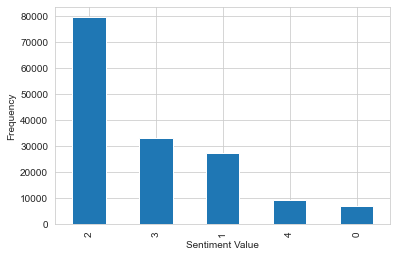

In [14]:
#create a bar plot to visualize how many observations/phrases are in each sentiment class
senplot = train['Sentiment'].value_counts()
senplot.plot(kind='bar', xlabel='Sentiment Value', ylabel='Frequency')

We added a phrase length conlumn based for regular Phrase column, and created visualizations to show some basic statistics.

In [15]:
#add Phrase_len column that saves the length of each phrase
train['Phrase_len'] = train.Phrase.apply(len)

<AxesSubplot:ylabel='Frequency'>

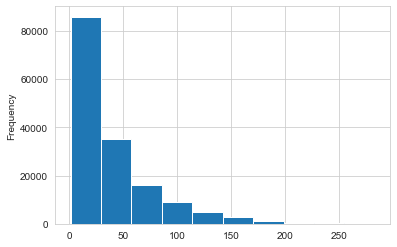

In [16]:
#create a histogram for phrase length
train['Phrase_len'].plot(kind='hist')

<AxesSubplot:xlabel='Sentiment', ylabel='Phrase_len'>

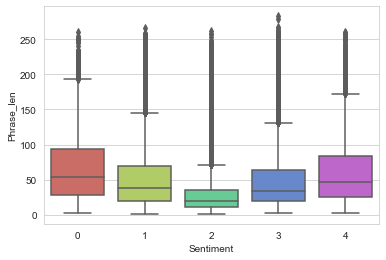

In [17]:
#create a boxplot to show distribution of phrase length in each sentiment class
sb.boxplot(x='Sentiment',y='Phrase_len', data = train, palette='hls')

#### Preprocessing

First, we would like to remove punctuation from each phrase

In [18]:
#create punctuation list that we wanted to remove from the text
punctuation = [",",".","?","!",":",";",'--',"''",'``','&',"(",")",'...','\\','//','*',"'",'`','$','-']

In [19]:
#create function that can simplify text by removing any punctuation in the list we creatd above
def simplify_text(text):
    
    remove_punct = [c for c in text.split() if c not in punctuation]
    no_punc = ' '.join(remove_punct)
    
    return no_punc

In [20]:
#apply the function to Phrase column
train['Phrase'] = train.Phrase.apply(simplify_text)

In [18]:
#check the first phrase again
print(train.Phrase[0])

A series of escapades demonstrating the adage that what is good for the goose is also good for the gander some of which occasionally amuses but none of which amounts to much of a story


Then, we created a new column for stemmed Phrases

In [19]:
#create a fucntion that performs text stemming using the Porter Stemmer
def text_stemming(text):
    
    porter = nltk.PorterStemmer()
    
    Stem = [porter.stem(t) for t in text.split()] 
    
    return ' '.join(Stem)

In [20]:
#apply the function to Phrase column and add results to a new column
train['Stemmed_Phrase'] = train.Phrase.apply(text_stemming)

In [21]:
#we would like to drop rows that no longer have text in Phrase columns 
train = train.replace(r'^s*$','NaN',regex=True)
train = train[train['Phrase']!= 'NaN']
train = train[train['Stemmed_Phrase']!= 'NaN']

In [22]:
#review the final train set
train

,PhraseId,SentenceId,Phrase,Sentiment,Phrase_len,Stemmed_Phrase
0,1,1,A series of escapades demonstrating the adage ...,1,188,a seri of escapad demonstr the adag that what ...
1,2,1,A series of escapades demonstrating the adage ...,2,77,a seri of escapad demonstr the adag that what ...
2,3,1,A series,2,8,a seri
3,4,1,A,2,1,a
4,5,1,series,2,6,seri
...,...,...,...,...,...,...
156055,156056,8544,Hearst 's,2,9,hearst 's
156056,156057,8544,forced avuncular chortles,1,25,forc avuncular chortl
156057,156058,8544,avuncular chortles,3,18,avuncular chortl
156058,156059,8544,avuncular,2,9,avuncular


In [23]:
#check the observations in each sentiment class
train['Sentiment'].value_counts() 

2    79566
3    32927
1    27272
4     9206
0     7072
Name: Sentiment, dtype: int64

In [24]:
#remove duplicates in the Stemmed_Phrase
train1 = train.drop_duplicates(subset='Stemmed_Phrase')
train1

,PhraseId,SentenceId,Phrase,Sentiment,Phrase_len,Stemmed_Phrase
0,1,1,A series of escapades demonstrating the adage ...,1,188,a seri of escapad demonstr the adag that what ...
1,2,1,A series of escapades demonstrating the adage ...,2,77,a seri of escapad demonstr the adag that what ...
2,3,1,A series,2,8,a seri
3,4,1,A,2,1,a
4,5,1,series,2,6,seri
...,...,...,...,...,...,...
156055,156056,8544,Hearst 's,2,9,hearst 's
156056,156057,8544,forced avuncular chortles,1,25,forc avuncular chortl
156057,156058,8544,avuncular chortles,3,18,avuncular chortl
156058,156059,8544,avuncular,2,9,avuncular


In [25]:
#Check the observations in each Sentiment class again.
train1['Sentiment'].value_counts() #for train data without duplicate Stemmed_Phrase

2    69194
3    27766
1    22954
4     7499
0     5684
Name: Sentiment, dtype: int64

### Model Comparison

#### Vectorization

In [26]:
#save the values in the regular phrase and sentiment columns to new variables
train_x = train['Phrase'].values
train_y = train['Sentiment'].values

In [27]:
#split data into train and validation sets
new_train_x, new_test_x, new_train_y, new_test_y = train_test_split(train_x,train_y,test_size = 0.30,
                                                                                            random_state=11)

In [28]:
#save the values in the stemmed phrase and sentiment columns to new variables
train_x2 = train1['Stemmed_Phrase'].values
train_y2 = train1['Sentiment'].values

In [29]:
#split data into train and validation sets
new_train_x2, new_test_x2, new_train_y2, new_test_y2 = train_test_split(train_x2,train_y2,test_size = 0.30,
                                                                                            random_state=11)

Next, we performed tf-idf transformation using unigram feature only

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(encoding='latin-1', min_df=5)

#transform regular phrase vectors
tfidf_x_vectors_all = tfidf.fit_transform(train_x)
tfidf_x_vectors = tfidf.fit_transform(new_train_x)

#transform stemmed phrase vectors
tfidf_x_vectors2_all = tfidf.fit_transform(train_x2)
tfidf_x_vectors2 = tfidf.fit_transform(new_train_x2) 

Lastly, we performed tf-idf transformation and use N-gram feature

In [31]:
#we also create vectors that include unigram, bigram and trigrams
ntfidf = TfidfVectorizer(encoding='latin-1', min_df=5,ngram_range = (1,3))

#transform regular phrase vectors
ntfidf_x_vectors_all = ntfidf.fit_transform(train_x)
ntfidf_x_vectors = ntfidf.fit_transform(new_train_x)

#transform stemmed phrase vectors
ntfidf_x_vectors2_all = ntfidf.fit_transform(train_x2)
ntfidf_x_vectors2 = ntfidf.fit_transform(new_train_x2) 

In [32]:
type(tfidf_x_vectors)

scipy.sparse.csr.csr_matrix

#### Multinomial Naive Bayes

First, we used the Multinomial Naive Bayes classifier and performed parameter tuning using RandomizedSearchCV.

In [53]:
#find the best parameters when using unigram and 70% of the original phrases
kFolds = 3
MNB = MultinomialNB()
distributions = dict(alpha=list(np.arange(0.05,3.0,0.05)))
tfidf_nb = RandomizedSearchCV(MNB, distributions, cv=kFolds)
search = tfidf_nb.fit(tfidf_x_vectors, new_train_y)
search.best_params_

{'alpha': 0.1}

We noticed the result above varies every time we run the code. We found better results when alpha equals to 0.1.

In [56]:
kFolds = 3
tfidf_nb = MultinomialNB(alpha=0.1)
y_pred_MNB = cross_val_predict(tfidf_nb, tfidf_x_vectors, new_train_y, cv=kFolds)

# classification report compares predictions from the k fold test sets with the gold
print(classification_report(new_train_y, y_pred_MNB))

              precision    recall  f1-score   support

           0       0.47      0.15      0.23      4889
           1       0.49      0.32      0.39     19113
           2       0.63      0.84      0.72     55784
           3       0.52      0.42      0.46     23060
           4       0.51      0.17      0.25      6384

    accuracy                           0.59    109230
   macro avg       0.52      0.38      0.41    109230
weighted avg       0.57      0.59      0.56    109230



Accuracy was lower when using default parameters. 

In [57]:
# confusion matrix
cm_MNB = confusion_matrix(new_train_y, y_pred_MNB)
print('\n')
print(pd.crosstab(new_train_y, y_pred_MNB, rownames=['Actual'], colnames=['Predicted'], margins=True))



Predicted     0      1      2      3     4     All
Actual                                            
0           750   2062   1981     93     3    4889
1           598   6167  11605    712    31   19113
2           216   3852  46596   4885   235   55784
3            22    536  12006   9742   754   23060
4             2     52   1817   3445  1068    6384
All        1588  12669  74005  18877  2091  109230


Around 3.5% negative phrases (class 0 and 1) were misclassified as positive (class 3 and 4), and around 2.1% positive phrases were misclassified as negative.

In [91]:
#then we used unigram and 70% of the stemmed phrase
kFolds = 3
MNB = MultinomialNB()
distributions = dict(alpha=list(np.arange(0.05,3.0,0.05)))
tfidf_nb = RandomizedSearchCV(MNB, distributions, cv=kFolds)
search = tfidf_nb.fit(tfidf_x_vectors2, new_train_y2)
search.best_params_

{'alpha': 0.05}

In [92]:
#calculate 3-fold cv evaluation metrics for stemmed phrases.
kFolds = 3
tfidf_nb = MultinomialNB(alpha=0.05)
y_pred_nb2 = cross_val_predict(tfidf_nb, tfidf_x_vectors2, new_train_y2, cv=kFolds)

# classification report compares predictions from the k fold test sets with the gold
print(classification_report(new_train_y2, y_pred_nb2))

              precision    recall  f1-score   support

           0       0.46      0.13      0.20      4023
           1       0.50      0.29      0.37     16173
           2       0.62      0.86      0.72     48442
           3       0.51      0.36      0.42     19277
           4       0.51      0.14      0.21      5252

    accuracy                           0.59     93167
   macro avg       0.52      0.36      0.39     93167
weighted avg       0.56      0.59      0.55     93167



In [93]:
# confusion matrix
cm_MNB2 = confusion_matrix(new_train_y2, y_pred_nb2)
#print_cm(cm, labels)
print('\n')
print(pd.crosstab(new_train_y2, y_pred_nb2, rownames=['Actual'], colnames=['Predicted'], margins=True))



Predicted     0     1      2      3     4    All
Actual                                          
0           525  1587   1846     65     0   4023
1           427  4695  10565    468    18  16173
2           171  2766  41879   3451   175  48442
3            18   361  11392   6999   507  19277
4             2    41   1799   2694   716   5252
All        1143  9450  67481  13677  1416  93167


Around 2.7% negative phrases (class 0 and 1) were misclassified as positive (class 3 and 4), and around 1.7% positive phrases were misclassified as negative.

Based on our experiments, when using 70% of data, original phrases produced better results with higher overall F1-Score.

In [123]:
#using unigram and 100% original phrases
kFolds = 3
MNB = MultinomialNB()
distributions = dict(alpha=list(np.arange(0.05,3.0,0.05)))
tfidf_nb = RandomizedSearchCV(MNB, distributions, cv=kFolds)
search = tfidf_nb.fit(tfidf_x_vectors_all, train_y)
search.best_params_

{'alpha': 0.9500000000000001}

In [124]:
#calculate 3-fold cv evaluation metrics
kFolds = 3
tfidf_nb = MultinomialNB(alpha=0.95)
y_pred_nb_final = cross_val_predict(tfidf_nb, tfidf_x_vectors_all, train_y, cv=kFolds)

# classification report compares predictions from the k fold test sets with the gold
print(classification_report(train_y, y_pred_nb_final))

              precision    recall  f1-score   support

           0       0.40      0.01      0.03      7072
           1       0.43      0.18      0.25     27272
           2       0.58      0.89      0.70     79566
           3       0.48      0.33      0.39     32927
           4       0.36      0.03      0.05      9206

    accuracy                           0.55    156043
   macro avg       0.45      0.29      0.28    156043
weighted avg       0.51      0.55      0.49    156043



In [125]:
# confusion matrix
cm_MNB = confusion_matrix(train_y, y_pred_nb_final)
#print_cm(cm, labels)
print('\n')
print(pd.crosstab(train_y, y_pred_nb_final, rownames=['Actual'], colnames=['Predicted'], margins=True))



Predicted    0      1       2      3    4     All
Actual                                           
0           93   2338    4431    202    8    7072
1           80   4857   21134   1172   29   27272
2           51   3450   70507   5387  171   79566
3            9    597   21213  10877  231   32927
4            0     68    3889   5003  246    9206
All        233  11310  121174  22641  685  156043


In [106]:
#using unigram and 100% stemmed phrases
kFolds = 3
MNB = MultinomialNB()
distributions = dict(alpha=list(np.arange(0.05,3.0,0.05)))
tfidf_nb = RandomizedSearchCV(MNB, distributions, cv=kFolds)
search = tfidf_nb.fit(tfidf_x_vectors2_all, train_y2)
search.best_params_

{'alpha': 0.7500000000000001}

In [127]:
#calculate 3-fold cv evaluation metrics
kFolds = 3
tfidf_nb = MultinomialNB(alpha=0.75)
y_pred_nb_final2 = cross_val_predict(tfidf_nb, tfidf_x_vectors2_all, train_y2, cv=kFolds)

# classification report compares predictions from the k fold test sets with the gold
print(classification_report(train_y2, y_pred_nb_final2))

              precision    recall  f1-score   support

           0       0.32      0.01      0.03      5684
           1       0.44      0.18      0.25     22954
           2       0.59      0.89      0.71     69194
           3       0.48      0.31      0.38     27766
           4       0.37      0.03      0.06      7499

    accuracy                           0.56    133097
   macro avg       0.44      0.29      0.28    133097
weighted avg       0.52      0.56      0.50    133097



In [128]:
# confusion matrix
cm_MNB = confusion_matrix(train_y2, y_pred_nb_final2)
#print_cm(cm, labels)
print('\n')
print(pd.crosstab(train_y2, y_pred_nb_final2, rownames=['Actual'], colnames=['Predicted'], margins=True))



Predicted    0     1       2      3    4     All
Actual                                          
0           83  1886    3603    106    6    5684
1           89  4083   17943    814   25   22954
2           80  2835   61684   4412  183   69194
3            9   441   18507   8620  189   27766
4            0    35    3330   3899  235    7499
All        261  9280  105067  17851  638  133097


The overall accuracy, precision, recall and f1-score were lower when using the entire data set. Using stemmed phrases generated better results.

In [117]:
#lastly we tried using ngram vectors and 100% stemmed phrase
kFolds = 3
MNB = MultinomialNB()
distributions = dict(alpha=list(np.arange(0.05,3.0,0.05)))
ntfidf_nb = RandomizedSearchCV(MNB, distributions, cv=kFolds)
search = ntfidf_nb.fit(ntfidf_x_vectors2_all, train_y2)
search.best_params_

{'alpha': 0.45}

In [118]:
#calculate 3-fold cv evaluation metrics
kFolds = 3
ntfidf_nb = MultinomialNB(alpha=0.45)
y_pred_nb_final2 = cross_val_predict(ntfidf_nb, ntfidf_x_vectors2_all, train_y2, cv=kFolds)

# classification report compares predictions from the k fold test sets with the gold
print(classification_report(train_y2, y_pred_nb_final2))

              precision    recall  f1-score   support

           0       0.22      0.02      0.04      5684
           1       0.40      0.29      0.34     22954
           2       0.63      0.81      0.71     69194
           3       0.45      0.40      0.42     27766
           4       0.28      0.07      0.11      7499

    accuracy                           0.56    133097
   macro avg       0.40      0.32      0.32    133097
weighted avg       0.51      0.56      0.52    133097



In [119]:
# confusion matrix
cm_MNB = confusion_matrix(train_y2, y_pred_nb_final2)
#print_cm(cm, labels)
print('\n')
print(pd.crosstab(train_y2, y_pred_nb_final2, rownames=['Actual'], colnames=['Predicted'], margins=True))



Predicted    0      1      2      3     4     All
Actual                                           
0          125   2813   2383    314    49    5684
1          243   6645  14204   1716   146   22954
2          154   5572  56218   6733   517   69194
3           36   1324  14792  10990   624   27766
4            3    149   2201   4624   522    7499
All        561  16503  89798  24377  1858  133097


Around 7.8% negative phrases (class 0 and 1) were misclassified as positive (class 3 and 4), and around 4.3% positive phrases were misclassified as negative.

Based on results above, using stemmed phrases and ngrams had better overall accuracy and precision.

#### Support Vector Machines

We then used the Linear Support Vector Classification model. We chose this classifier because it works better on very large data set.

In [48]:
#find the best parameters when using unigram and 70% of the original phrases
kFolds = 3
SVM = LinearSVC(class_weight='balanced')
distributions = dict(C=list(np.arange(0.1,3.0,0.1)))
tfidf_svm = RandomizedSearchCV(SVM, distributions, cv=kFolds)
search = tfidf_svm.fit(tfidf_x_vectors, new_train_y)
search.best_params_

{'C': 0.30000000000000004}

In [49]:
#using unigram and 70% of original phrases
kFolds = 3
tfidf_svm = LinearSVC(C=0.3,class_weight='balanced')
y_pred_svm = cross_val_predict(tfidf_svm, tfidf_x_vectors, new_train_y, cv=kFolds)

# classification report compares predictions from the k fold test sets with the gold
print(classification_report(new_train_y, y_pred_svm))

              precision    recall  f1-score   support

           0       0.32      0.52      0.40      4889
           1       0.49      0.44      0.46     19113
           2       0.74      0.73      0.74     55784
           3       0.53      0.45      0.49     23060
           4       0.38      0.55      0.45      6384

    accuracy                           0.60    109230
   macro avg       0.49      0.54      0.51    109230
weighted avg       0.61      0.60      0.61    109230



In [50]:
# confusion matrix
cm_SVM = confusion_matrix(new_train_y, y_pred_svm)
#print_cm(cm, labels)
print('\n')
print(pd.crosstab(new_train_y, y_pred_svm, rownames=['Actual'], colnames=['Predicted'], margins=True))



Predicted     0      1      2      3     4     All
Actual                                            
0          2561   1753    436     83    56    4889
1          3406   8483   6024    899   301   19113
2          1581   6088  40958   5971  1186   55784
3           347   1029   7173  10346  4165   23060
4            45    101    436   2302  3500    6384
All        7940  17454  55027  19601  9208  109230


Around 5.6% negative phrases (class 0 and 1) were misclassified as positive (class 3 and 4), and around 5.2% positive phrases were misclassified as negative.

In [51]:
#using unigram and 70% of stemmed phrases
kFolds = 3
SVM = LinearSVC(class_weight='balanced')
distributions = dict(C=list(np.arange(0.1,3.0,0.1)))
tfidf_svm = RandomizedSearchCV(SVM, distributions, cv=kFolds)
search = tfidf_svm.fit(tfidf_x_vectors2, new_train_y2)
search.best_params_

{'C': 0.4}

In [52]:
kFolds = 3
tfidf_svm = LinearSVC(C=0.4, class_weight='balanced')
y_pred_svm2 = cross_val_predict(tfidf_svm, tfidf_x_vectors2, new_train_y2, cv=kFolds)

# classification report compares predictions from the k fold test sets with the gold
print(classification_report(new_train_y2, y_pred_svm2))

              precision    recall  f1-score   support

           0       0.30      0.49      0.38      4023
           1       0.48      0.44      0.46     16173
           2       0.75      0.73      0.74     48442
           3       0.51      0.44      0.47     19277
           4       0.36      0.55      0.44      5252

    accuracy                           0.60     93167
   macro avg       0.48      0.53      0.50     93167
weighted avg       0.61      0.60      0.60     93167



In [53]:
# confusion matrix
cm_SVM2 = confusion_matrix(new_train_y2, y_pred_svm2)
#print_cm(cm, labels)
print('\n')
print(pd.crosstab(new_train_y2, y_pred_svm2, rownames=['Actual'], colnames=['Predicted'], margins=True))



Predicted     0      1      2      3     4    All
Actual                                           
0          1982   1501    381     93    66   4023
1          2792   7161   5018    920   282  16173
2          1374   5285  35198   5384  1201  48442
3           334    957   5926   8565  3495  19277
4            46    104    369   1851  2882   5252
All        6528  15008  46892  16813  7926  93167


Around 6.7% negative phrases (class 0 and 1) were misclassified as positive (class 3 and 4), and around 5.9% positive phrases were misclassified as negative.

Comparing results above, using original phrases produced better results since it had higher weighted avg F1-Score.

In [63]:
#then we used unigram and the 100% of original phrase data to train the classifier
kFolds = 3
SVM = LinearSVC(class_weight='balanced')
distributions = dict(C=list(np.arange(0.01,3.0,0.05)))
tfidf_svm = RandomizedSearchCV(SVM, distributions, cv=kFolds)
search = tfidf_svm.fit(tfidf_x_vectors_all, train_y)
search.best_params_

{'C': 0.21000000000000002}

In [64]:
kFolds = 3
tfidf_svm = LinearSVC(C=0.21, class_weight='balanced')
y_pred_svm_all = cross_val_predict(tfidf_svm, tfidf_x_vectors_all, train_y, cv=kFolds)

# classification report compares predictions from the k fold test sets with the gold
print(classification_report(train_y, y_pred_svm_all))

              precision    recall  f1-score   support

           0       0.28      0.37      0.32      7072
           1       0.43      0.32      0.36     27272
           2       0.69      0.76      0.72     79566
           3       0.49      0.38      0.42     32927
           4       0.33      0.45      0.38      9206

    accuracy                           0.57    156043
   macro avg       0.44      0.45      0.44    156043
weighted avg       0.56      0.57      0.56    156043



In [65]:
# confusion matrix
cm_SVM = confusion_matrix(train_y, y_pred_svm_all)
#print_cm(cm, labels)
print('\n')
print(pd.crosstab(train_y, y_pred_svm_all, rownames=['Actual'], colnames=['Predicted'], margins=True))



Predicted     0      1      2      3      4     All
Actual                                             
0          2600   2400   1559    309    204    7072
1          3679   8701  12240   1933    719   27272
2          2194   7179  60838   7414   1941   79566
3           739   1893  12594  12372   5329   32927
4           131    295   1195   3464   4121    9206
All        9343  20468  88426  25492  12314  156043


In [33]:
#then we used unigram and the 100% of the stemmed phrase
kFolds = 3
SVM = LinearSVC(class_weight='balanced')
distributions = dict(C=list(np.arange(0.01,3.0,0.05)))
tfidf_svm = RandomizedSearchCV(SVM, distributions, cv=kFolds)
search = tfidf_svm.fit(tfidf_x_vectors2_all, train_y2)
search.best_params_

{'C': 0.66}

In [34]:
kFolds = 3
tfidf_svm = LinearSVC(C=0.66, class_weight='balanced')
y_pred_svm_all2 = cross_val_predict(tfidf_svm, tfidf_x_vectors2_all, train_y2, cv=kFolds)

# classification report compares predictions from the k fold test sets with the gold
print(classification_report(train_y2, y_pred_svm_all2))

              precision    recall  f1-score   support

           0       0.25      0.35      0.29      5684
           1       0.42      0.35      0.38     22954
           2       0.71      0.74      0.72     69194
           3       0.47      0.39      0.43     27766
           4       0.33      0.47      0.39      7499

    accuracy                           0.57    133097
   macro avg       0.44      0.46      0.44    133097
weighted avg       0.57      0.57      0.56    133097



In [35]:
# confusion matrix
cm_SVM = confusion_matrix(train_y2, y_pred_svm_all2)
#print_cm(cm, labels)
print('\n')
print(pd.crosstab(train_y2, y_pred_svm_all2, rownames=['Actual'], colnames=['Predicted'], margins=True))



Predicted     0      1      2      3      4     All
Actual                                             
0          1981   2169   1110    266    158    5684
1          3196   8026   9338   1772    622   22954
2          1897   7000  51040   7379   1878   69194
3           682   1659  10028  10899   4498   27766
4           144    213    821   2804   3517    7499
All        7900  19067  72337  23120  10673  133097


Per results above, using original and stemmed phrases had same overall accuracy, but using original phrases produced higher weighted average f1-score.

In [110]:
#lastly, we also tried using ngram and 100% original phrases
kFolds = 3
SVM = LinearSVC(class_weight='balanced')
distributions = dict(C=list(np.arange(0.01,3.0,0.05)))
ntfidf_svm = RandomizedSearchCV(SVM, distributions, cv=kFolds)
search = ntfidf_svm.fit(ntfidf_x_vectors_all, train_y)
search.best_params_

{'C': 0.16000000000000003}

In [111]:
kFolds = 3
ntfidf_svm = LinearSVC(C=0.16, class_weight='balanced')
y_pred_svm_all3 = cross_val_predict(ntfidf_svm, ntfidf_x_vectors_all, train_y, cv=kFolds)

# classification report compares predictions from the k fold test sets with the gold
print(classification_report(train_y, y_pred_svm_all3))

              precision    recall  f1-score   support

           0       0.33      0.24      0.28      7072
           1       0.42      0.25      0.32     27272
           2       0.63      0.84      0.72     79566
           3       0.50      0.32      0.39     32927
           4       0.38      0.33      0.36      9206

    accuracy                           0.57    156043
   macro avg       0.45      0.40      0.41    156043
weighted avg       0.54      0.57      0.54    156043



In [112]:
# confusion matrix
cm_SVM = confusion_matrix(train_y, y_pred_svm_all3)
#print_cm(cm, labels)
print('\n')
print(pd.crosstab(train_y, y_pred_svm_all3, rownames=['Actual'], colnames=['Predicted'], margins=True))



Predicted     0      1       2      3     4     All
Actual                                             
0          1694   2292    2711    268   107    7072
1          2001   6874   16678   1358   361   27272
2          1087   5508   66643   5190  1138   79566
3           309   1329   17360  10554  3375   32927
4            64    214    2196   3666  3066    9206
All        5155  16217  105588  21036  8047  156043


Around 6.1% negative phrases (class 0 and 1) were misclassified as postive (class 3 and 4), and around 4.5% positive phrases were misclassified as negative.

In [36]:
#we also tried using ngram and 100% stemmed phrases
kFolds = 3
SVM = LinearSVC(class_weight='balanced')
distributions = dict(C=list(np.arange(0.01,3.0,0.05)))
ntfidf_svm = RandomizedSearchCV(SVM, distributions, cv=kFolds)
search = ntfidf_svm.fit(ntfidf_x_vectors2_all, train_y2)
search.best_params_

{'C': 0.21000000000000002}

In [39]:
kFolds = 3
ntfidf_svm = LinearSVC(C=0.21, class_weight='balanced')
y_pred_svm_all4 = cross_val_predict(ntfidf_svm, ntfidf_x_vectors2_all, train_y2, cv=kFolds)

# classification report compares predictions from the k fold test sets with the gold
print(classification_report(train_y2, y_pred_svm_all4))

              precision    recall  f1-score   support

           0       0.30      0.25      0.28      5684
           1       0.43      0.27      0.33     22954
           2       0.65      0.82      0.73     69194
           3       0.50      0.35      0.41     27766
           4       0.37      0.34      0.36      7499

    accuracy                           0.58    133097
   macro avg       0.45      0.41      0.42    133097
weighted avg       0.55      0.58      0.55    133097



In [40]:
# confusion matrix
cm_SVM = confusion_matrix(train_y2, y_pred_svm_all4)
#print_cm(cm, labels)
print('\n')
print(pd.crosstab(train_y2, y_pred_svm_all4, rownames=['Actual'], colnames=['Predicted'], margins=True))



Predicted     0      1      2      3     4     All
Actual                                            
0          1445   1986   1942    220    91    5684
1          1942   6142  13373   1194   303   22954
2          1019   4914  57023   5187  1051   69194
3           293   1102  13901   9586  2884   27766
4            65    165   1510   3173  2586    7499
All        4764  14309  87749  19360  6915  133097


Around 6.3% negative phrases (class 0 and 1) were misclassified as positive (class 3 and 4), and around 4.6% positive phrases were misclassified as negative.

Overall, ngram vectors had better accuracy when using stemmed phrases, and unigram feature using original phrases had slightly lower accuracy but higher F1-score.

#### Random Forest

In [27]:
#find the best parameters when using unigram and 70% of the original phrases
kFolds = 3
rf = RandomForestClassifier()
distributions = dict(n_estimators =[10,50,100],min_samples_leaf=[3,5,10])
tfidf_rf = GridSearchCV(rf, distributions, cv=kFolds)
search = tfidf_rf.fit(tfidf_x_vectors, new_train_y)
search.best_params_

{'min_samples_leaf': 3, 'n_estimators': 100}

We only included min_samples_leaf values of 3,5 and 10, and only included n_estimators of 10, 50 and 100 in the search grid to save model train time due to the size of our data.

In [28]:
#creating a RF classifier
tfidf_rf = RandomForestClassifier(n_estimators = 100,min_samples_leaf=3) 

kFolds = 3
y_pred_rf = cross_val_predict(tfidf_rf, tfidf_x_vectors, new_train_y, cv=kFolds)

# classification report compares predictions from the k fold test sets with the gold
print(classification_report(new_train_y, y_pred_rf))

              precision    recall  f1-score   support

           0       0.60      0.06      0.11      4889
           1       0.54      0.18      0.27     19113
           2       0.59      0.93      0.72     55784
           3       0.53      0.32      0.40     23060
           4       0.60      0.07      0.12      6384

    accuracy                           0.58    109230
   macro avg       0.57      0.31      0.33    109230
weighted avg       0.57      0.58      0.51    109230



In [29]:
# confusion matrix
cm_rf = confusion_matrix(new_train_y, y_pred_rf)
#print_cm(cm, labels)
print('\n')
print(pd.crosstab(new_train_y, y_pred_rf, rownames=['Actual'], colnames=['Predicted'], margins=True))



Predicted    0     1      2      3    4     All
Actual                                         
0          303  1389   3025    170    2    4889
1          166  3514  14799    629    5   19113
2           32  1425  51928   2350   49   55784
3            1   162  15221   7453  223   23060
4            0    21   2603   3342  418    6384
All        502  6511  87576  13944  697  109230


Around 3.4% negative phrases (class 0 and 1) were misclassified as postive (class 3 and 4), and around 0.6% positive phrases were misclassified as negative.

In [30]:
#find the best parameters when using unigram and 70% of stemmed phrase vector
kFolds = 3
rf = RandomForestClassifier()
distributions = dict(n_estimators =[10,50,100],min_samples_leaf=[3,5,10])
tfidf_rf = GridSearchCV(rf, distributions, cv=kFolds)
search = tfidf_rf.fit(tfidf_x_vectors2, new_train_y2)
search.best_params_

{'min_samples_leaf': 3, 'n_estimators': 100}

In [31]:
#creating a RF classifier
tfidf_rf2 = RandomForestClassifier(n_estimators = 100,min_samples_leaf=3) 

kFolds = 3
y_pred_rf2 = cross_val_predict(tfidf_rf2, tfidf_x_vectors2, new_train_y2, cv=kFolds)

# classification report compares predictions from the k fold test sets with the gold
print(classification_report(new_train_y2, y_pred_rf2))

              precision    recall  f1-score   support

           0       0.62      0.05      0.09      4023
           1       0.53      0.18      0.27     16173
           2       0.60      0.93      0.73     48442
           3       0.52      0.32      0.40     19277
           4       0.65      0.05      0.09      5252

    accuracy                           0.58     93167
   macro avg       0.58      0.31      0.31     93167
weighted avg       0.57      0.58      0.52     93167



In [32]:
# confusion matrix
cm_rf = confusion_matrix(new_train_y2, y_pred_rf2)
#print_cm(cm, labels)
print('\n')
print(pd.crosstab(new_train_y2, y_pred_rf2, rownames=['Actual'], colnames=['Predicted'], margins=True))



Predicted    0     1      2      3    4    All
Actual                                        
0          203  1121   2553    146    0   4023
1          105  2924  12533    609    2  16173
2           21  1257  44897   2243   24  48442
3            1   217  12769   6183  107  19277
4            0    30   2199   2776  247   5252
All        330  5549  74951  11957  380  93167


Around 3.7% negative phrases (class 0 and 1) were misclassified as positive (class 3 and 4), and around 1.0% positive phrases were misclassified as negative.

Comparing results above, using stemmed phrases produced better results since it had higher weighted avg F1-Score.

In [41]:
#we then use the entire data set
#find the best parameters when using unigram and 100% of the original phrases
kFolds = 3
rf = RandomForestClassifier()
distributions = dict(n_estimators =[10,50,100],min_samples_leaf=[3,5,10])
tfidf_rf = GridSearchCV(rf, distributions, cv=kFolds)
search = tfidf_rf.fit(tfidf_x_vectors_all, train_y)
search.best_params_

{'min_samples_leaf': 3, 'n_estimators': 100}

In [42]:
#creating a RF classifier
tfidf_rf_all = RandomForestClassifier(n_estimators = 100,min_samples_leaf=3) 

kFolds = 3
y_pred_rf_all = cross_val_predict(tfidf_rf_all, tfidf_x_vectors_all, train_y, cv=kFolds)

# classification report compares predictions from the k fold test sets with the gold
print(classification_report(train_y, y_pred_rf_all))

              precision    recall  f1-score   support

           0       0.46      0.02      0.04      7072
           1       0.46      0.12      0.19     27272
           2       0.57      0.94      0.71     79566
           3       0.48      0.26      0.34     32927
           4       0.53      0.04      0.07      9206

    accuracy                           0.56    156043
   macro avg       0.50      0.27      0.27    156043
weighted avg       0.53      0.56      0.47    156043



In [43]:
# confusion matrix
cm_rf = confusion_matrix(train_y, y_pred_rf_all)
#print_cm(cm, labels)
print('\n')
print(pd.crosstab(train_y, y_pred_rf_all, rownames=['Actual'], colnames=['Predicted'], margins=True))



Predicted    0     1       2      3    4     All
Actual                                          
0          133  1410    5122    404    3    7072
1          122  3200   22613   1327   10   27272
2           34  1788   74425   3264   55   79566
3            1   429   23636   8610  251   32927
4            0    84    4496   4266  360    9206
All        290  6911  130292  17871  679  156043


In [33]:
#find the best parameters when using unigram and 100% of the stemmed phrases
kFolds = 3
rf = RandomForestClassifier()
distributions = dict(n_estimators =[10,50,100],min_samples_leaf=[3,5,10])
tfidf_rf = GridSearchCV(rf, distributions, cv=kFolds)
search = tfidf_rf.fit(tfidf_x_vectors2_all, train_y2)
search.best_params_

{'min_samples_leaf': 3, 'n_estimators': 50}

In [34]:
#creating a RF classifier
tfidf_rf2_all = RandomForestClassifier(n_estimators = 50,min_samples_leaf=3) 

kFolds = 3
y_pred_rf2_all = cross_val_predict(tfidf_rf2_all, tfidf_x_vectors2_all, train_y2, cv=kFolds)

# classification report compares predictions from the k fold test sets with the gold
print(classification_report(train_y2, y_pred_rf2_all))

              precision    recall  f1-score   support

           0       0.43      0.02      0.03      5684
           1       0.48      0.14      0.21     22954
           2       0.58      0.93      0.72     69194
           3       0.48      0.28      0.35     27766
           4       0.53      0.03      0.05      7499

    accuracy                           0.57    133097
   macro avg       0.50      0.28      0.27    133097
weighted avg       0.54      0.57      0.49    133097



In [35]:
# confusion matrix
cm_rf = confusion_matrix(train_y2, y_pred_rf2_all)
#print_cm(cm, labels)
print('\n')
print(pd.crosstab(train_y2, y_pred_rf2_all, rownames=['Actual'], colnames=['Predicted'], margins=True))



Predicted    0     1       2      3    4     All
Actual                                          
0           91  1260    3992    340    1    5684
1           84  3109   18626   1131    4   22954
2           28  1678   64241   3209   38   69194
3            6   368   19481   7770  141   27766
4            1    70    3578   3642  208    7499
All        210  6485  109918  16092  392  133097


Based on results above, using stemmed phrases had higher overall accuracy and weighed average f1-score.

In [36]:
#find the best parameters when using 100% of the original phrases and ngram
kFolds = 3
rf = RandomForestClassifier()
distributions = dict(n_estimators =[10,50,100],min_samples_leaf=[3,5,10])
ntfidf_rf = GridSearchCV(rf, distributions, cv=kFolds)
search = ntfidf_rf.fit(ntfidf_x_vectors2, new_train_y2)
search.best_params_

{'min_samples_leaf': 3, 'n_estimators': 100}

In [37]:
#creating a RF classifier
tfidf_rf2_all = RandomForestClassifier(n_estimators = 100,min_samples_leaf=3) 

kFolds = 3
y_pred_rf2_all2 = cross_val_predict(tfidf_rf2_all, ntfidf_x_vectors2_all, train_y2, cv=kFolds)

# classification report compares predictions from the k fold test sets with the gold
print(classification_report(train_y2, y_pred_rf2_all2))

              precision    recall  f1-score   support

           0       0.54      0.02      0.03      5684
           1       0.51      0.10      0.16     22954
           2       0.57      0.95      0.71     69194
           3       0.51      0.23      0.32     27766
           4       0.60      0.04      0.07      7499

    accuracy                           0.56    133097
   macro avg       0.54      0.27      0.26    133097
weighted avg       0.55      0.56      0.47    133097



In [38]:
# confusion matrix
cm_rf = confusion_matrix(train_y2, y_pred_rf2_all2)
#print_cm(cm, labels)
print('\n')
print(pd.crosstab(train_y2, y_pred_rf2_all2, rownames=['Actual'], colnames=['Predicted'], margins=True))



Predicted    0     1       2      3    4     All
Actual                                          
0           94   898    4529    155    8    5684
1           59  2203   20104    579    9   22954
2           19  1105   65719   2320   31   69194
3            2   137   21073   6417  137   27766
4            0    18    4032   3175  274    7499
All        174  4361  115457  12646  459  133097


Around 2.6% negative phrases (class 0 and 1) were misclassified as positive (class 3 and 4), and around 0.4% positive phrases were misclassified as negative.

Overall, when using the random forest classifier, we obtained better results using unigram feature and stemmed phrases.

In the end, based on results obtained from all experiments we conducted for each model, linearSVC classifier produced the best 3-fold cross-validation results.

### Feature engineering using NLTK

We then started using nltk package to generate and compare different features to perform classification analysis.

In [21]:
# read train data again and save it in a list that can be processed by nltk 
f = open('/Users/zhen/Documents/DS@Syracuse/Q3/IST 664/Project/train.tsv', 'r')
# loop over lines in the file and use the first limit of them
phrasedata = []
for line in f:
    # ignore the first line starting with Phrase and read all lines
    if (not line.startswith('Phrase')):
    # remove final end of line character
        line = line.strip()
    # each line has 4 items separated by tabs
    # ignore the phrase and sentence ids, and keep the phrase and sentiment
    phrasedata.append(line.split('\t')[2:4])

In [22]:
#check the first five items in the list
phrasedata[0:5]

[['Phrase', 'Sentiment\n'],
 ['A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .',
  '1'],
 ['A series of escapades demonstrating the adage that what is good for the goose',
  '2'],
 ['A series', '2'],
 ['A', '2']]

In [23]:
#delete the column names
del phrasedata[0]

In [24]:
#review first five phrases and their labels
phrasedata[0:5]

[['A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .',
  '1'],
 ['A series of escapades demonstrating the adage that what is good for the goose',
  '2'],
 ['A series', '2'],
 ['A', '2'],
 ['series', '2']]

In [25]:
#check how many observations are in the data set
len(phrasedata)

156060

In [26]:
#shuffle all phrasedata
random.seed(11)
random.shuffle(phrasedata)

In [27]:
#check the updated first five phrases
for phrase in phrasedata[:5]:
    print (phrase)

['like Pearl Harbor', '2']
['acts', '2']
["by a weak script that ca n't support the epic treatment", '1']
['delicate coming-of-age tale', '3']
['the life out of whatever idealism American moviemaking ever had', '1']


In [28]:
# create list of phrase documents as (list of words, label)
phrasedocs = []
# add all the phrases
for phrase in phrasedata:
    tokens = nltk.word_tokenize(phrase[0])
    #convert every tokens to lowercase
    words = [w.lower() for w in tokens]
    # remove the punctuation
    punctuation = [",",".","?","!",":",";",'--',"''",'``','&',"(",")",'...','\\','//','*',"'",'`','$','-']
    words_nopunct = [w for w in words if not w in punctuation]
    phrasedocs.append((words_nopunct, int(phrase[1])))

We chose not to remove stop words because some phrases only include stop words.

In [50]:
#check the current first element in the phrasedocs
phrasedocs[0]

(['like', 'pearl', 'harbor'], 2)

In [30]:
# get all words and put them into a frequency distribution
phrase_words_list = [word for (sent,cat) in phrasedocs for word in sent]
phrase_words = nltk.FreqDist(phrase_words_list)

In [31]:
# get the 2000 most frequently appearing keywords
word_items = phrase_words.most_common(2000)

# create a word_features list that include tuples of word and its count
word_features = [word for (word,count) in word_items]

In [32]:
len(word_features)

2000

In [33]:
#print the top 30 most frequent words, the individual word count was normalized 
for items in word_items[0:30]:
    print(items[0], round(items[1]/len(phrase_words_list)*100,2),'%;\n')

the 4.89 %;

a 3.45 %;

of 3.08 %;

and 3.03 %;

to 2.14 %;

's 1.62 %;

in 1.31 %;

is 1.28 %;

that 1.18 %;

it 1.11 %;

as 0.82 %;

with 0.74 %;

for 0.71 %;

its 0.67 %;

film 0.64 %;

an 0.62 %;

movie 0.56 %;

this 0.54 %;

but 0.49 %;

be 0.47 %;

you 0.46 %;

on 0.45 %;

n't 0.38 %;

by 0.37 %;

more 0.37 %;

his 0.37 %;

about 0.35 %;

one 0.34 %;

not 0.34 %;

at 0.34 %;



We also tried using the top 1000 and 3000 most frequently appearing words to build our word features. However, we found that as accuracy increases with using more words, so does computing time. Therefore, we determined to use the top 2000 most frequent words for future analysis. 

In addition, we wanted to compare results using regular phrases to results using stemmed phrases. Therefore, we created word features for the stemmed phrases as well.

In [34]:
# create list of stemmed phrase documents as (list of words, label)
# the porter stemmer converts every token to lowercase
stemmed_phrasedocs = []
porter = nltk.PorterStemmer()
# add all the phrases
for phrase in phrasedata:
    tokens = nltk.word_tokenize(phrase[0])
    # remove the punctuations
    punctuations = [",",".","?","!",":",";",'--',"''",'``','&',"(",")",'...','\\','//','*',"'",'`','$','-']
    words_nopunct = [w for w in tokens if not w in punctuations]
    # perform stemming
    words_stem = [porter.stem(w) for w in words_nopunct]
    stemmed_phrasedocs.append((words_stem, int(phrase[1])))

In [51]:
# check the first element in the list
stemmed_phrasedocs[0]

(['like', 'pearl', 'harbor'], 2)

In [36]:
# get all words and put them into a frequency distribution
stemmed_phrase_words_list = [word for (sent,cat) in stemmed_phrasedocs for word in sent]
stemmed_phrase_words = nltk.FreqDist(stemmed_phrase_words_list)

In [37]:
# get the 2000 most frequently appearing keywords
stemmed_word_items = stemmed_phrase_words.most_common(2000)

# create word_features list for stemmed words
stemmed_word_features = [word for (word,count) in stemmed_word_items]
len(stemmed_word_features)

2000

In [38]:
#print the top 30 most frequent words
for items in stemmed_word_items[0:30]:
    print(items[0], round(items[1]/len(stemmed_phrase_words_list)*100,2),'%;\n')

the 4.89 %;

a 3.45 %;

of 3.08 %;

and 3.03 %;

to 2.14 %;

it 1.79 %;

's 1.62 %;

in 1.31 %;

is 1.28 %;

that 1.18 %;

as 0.82 %;

film 0.74 %;

with 0.74 %;

for 0.71 %;

movi 0.69 %;

an 0.62 %;

be 0.57 %;

thi 0.54 %;

but 0.49 %;

you 0.46 %;

on 0.45 %;

n't 0.38 %;

by 0.37 %;

more 0.37 %;

hi 0.37 %;

one 0.36 %;

about 0.35 %;

not 0.34 %;

at 0.34 %;

like 0.33 %;



In [39]:
#extract sentiment class labels and save the results to a list, this will be used to evaluate model predictions
label_list = [c for (d,c) in phrasedocs]
labels = list(set(label_list)) 

#### Create functions

In this section, we will create several functions to be used for model evaluation. In addition, we will create a function that can save features to a csv file. 

In [40]:
### Function to compute precision, recall and F1 for each label ###
# Input: list of provided labels, list of predicted labels (in same order)
# Output: returns lists of precision, recall and F1 for each label
def eval_measures(gold, predicted, labels):
    
    # these lists have values for each label 
    recall_list = []
    precision_list = []
    F1_list = []

    for lab in labels:
        # for each label, compare gold and predicted lists and compute values
        TP = FP = FN = TN = 0
        for i, val in enumerate(gold):
            if val == lab and predicted[i] == lab:  TP += 1
            if val == lab and predicted[i] != lab:  FN += 1
            if val != lab and predicted[i] == lab:  FP += 1
            if val != lab and predicted[i] != lab:  TN += 1
        # use these to compute recall, precision, F1
        # for small numbers, guard against dividing by zero in computing measures
        if (TP == 0) or (FP == 0) or (FN == 0):
          recall_list.append (0)
          precision_list.append (0)
          F1_list.append(0)
        else:
          recall = TP / (TP + FP)
          precision = TP / (TP + FN)
          recall_list.append(recall)
          precision_list.append(precision)
          F1_list.append( 2 * (recall * precision) / (recall + precision))

    # the evaluation measures in a table with one row per label
    return (precision_list, recall_list, F1_list)

In [41]:
### cross-validation using nltk NaiveBayesClassifier ###
# this function takes the number of folds, the feature sets and the labels
# it iterates over the folds, using different sections for training and testing in turn
# it prints the performance for each fold and the average performance at the end
def cross_validation_PRF(num_folds, featuresets, labels):
    subset_size = int(len(featuresets)/num_folds)
    print('Each fold size:', subset_size)
    # for the number of labels - start the totals lists with zeroes
    num_labels = len(labels)
    total_precision_list = [0] * num_labels
    total_recall_list = [0] * num_labels
    total_F1_list = [0] * num_labels
    accuracy_list = []

    # iterate over the folds
    for i in range(num_folds):
        test_this_round = featuresets[(i*subset_size):][:subset_size]
        train_this_round = featuresets[:(i*subset_size)] + featuresets[((i+1)*subset_size):]
        # train using train_this_round
        classifier = nltk.NaiveBayesClassifier.train(train_this_round)
        # evaluate against test_this_round to produce the gold and predicted labels
        goldlist = []
        predictedlist = []
        for (features, label) in test_this_round:
            goldlist.append(label)
            predictedlist.append(classifier.classify(features))

        # computes evaluation measures for this fold and
        #   returns list of measures for each label
        print('Fold', i)
        (precision_list, recall_list, F1_list) \
                  = eval_measures(goldlist, predictedlist, labels)
        
        # evaluate against test_this_round and save accuracy
        accuracy_this_round = nltk.classify.accuracy(classifier, test_this_round)
        accuracy_list.append(accuracy_this_round)
        
        # take off triple string to print precision, recall and F1 for each fold
        '''
        print('\tPrecision\tRecall\t\tF1')
        # print measures for each label
        for i, lab in enumerate(labels):
            print(lab, '\t', "{:10.3f}".format(precision_list[i]), \
              "{:10.3f}".format(recall_list[i]), "{:10.3f}".format(F1_list[i]))
        '''
        # for each label add to the sums in the total lists
        for i in range(num_labels):
            # for each label, add the 3 measures to the 3 lists of totals
            total_precision_list[i] += precision_list[i]
            total_recall_list[i] += recall_list[i]
            total_F1_list[i] += F1_list[i]

    # find precision, recall and F measure averaged over all rounds for all labels
    # compute averages from the totals lists
    precision_list = [tot/num_folds for tot in total_precision_list]
    recall_list = [tot/num_folds for tot in total_recall_list]
    F1_list = [tot/num_folds for tot in total_F1_list]
    # the evaluation measures in a table with one row per label
    print('\nAverage Precision\tRecall\t\tF1 \tPer Label')
    # print measures for each label
    for i, lab in enumerate(labels):
        print(lab, '\t', "{:10.3f}".format(precision_list[i]), \
          "{:10.3f}".format(recall_list[i]), "{:10.3f}".format(F1_list[i]))
    
    # find mean accuracy over all rounds
    print ('\nMean accuracy', sum(accuracy_list) / num_folds)
    
    # print macro average over all labels - treats each label equally
    print('\nMacro Average Precision\tRecall\t\tF1 \tOver All Labels')
    print('\t', "{:10.3f}".format(sum(precision_list)/num_labels), \
          "{:10.3f}".format(sum(recall_list)/num_labels), \
          "{:10.3f}".format(sum(F1_list)/num_labels))

    # for micro averaging, weight the scores for each label by the number of items
    #    this is better for labels with imbalance
    # first intialize a dictionary for label counts and then count them
    label_counts = {}
    for lab in labels:
      label_counts[lab] = 0 
    # count the labels
    for (doc, lab) in featuresets:
      label_counts[lab] += 1
    # make weights compared to the number of documents in featuresets
    num_docs = len(featuresets)
    label_weights = [(label_counts[lab] / num_docs) for lab in labels]
    print('\nLabel Counts', label_counts)
    #print('Label weights', label_weights)
    # print macro average over all labels
    print('Micro Average Precision\tRecall\t\tF1 \tOver All Labels')
    precision = sum([a * b for a,b in zip(precision_list, label_weights)])
    recall = sum([a * b for a,b in zip(recall_list, label_weights)])
    F1 = sum([a * b for a,b in zip(F1_list, label_weights)])
    print( '\t', "{:10.3f}".format(precision), \
      "{:10.3f}".format(recall), "{:10.3f}".format(F1))

In [42]:
import sys
### Function writeFeatureSets: ###
# takes featuresets defined in the nltk and convert them to csv file
# any feature value in the featuresets should not contain ",", "'" or " itself
# and write the file to the outpath location
def writeFeatureSets(featuresets, outpath):
    # open outpath for writing
    f = open(outpath, 'w')
    # get the feature names from the feature dictionary in the first featureset
    featurenames = featuresets[0][0].keys()
    # create the first line of the file as comma separated feature names
    #    with the word class as the last feature name
    featurenameline = ''
    for featurename in featurenames:
        # replace forbidden characters with text abbreviations
        featurename = featurename.replace(',','CM')
        featurename = featurename.replace("'","DQ")
        featurename = featurename.replace('"','QU')
        featurenameline += featurename + ','
    featurenameline += 'class'
    # write this as the first line in the csv file
    f.write(featurenameline)
    f.write('\n')
    # convert each feature set to a line in the file with comma separated feature values,
    # each feature value is converted to a string 
    #   for booleans this is the words true and false
    #   for numbers, this is the string with the number
    for featureset in featuresets:
        featureline = ''
        for key in featurenames:
            featureline += str(featureset[0][key]) + ','
        featureline += str(featureset[1])
        # write each feature set values to the file
        f.write(featureline)
        f.write('\n')
    f.close()

### Feature sets development and comparison

#### Unigram feature

In [24]:
#### Create features for a BOW/unigram baseline ####
# each feature is 'V_keyword' and is true or false depending on whether that keyword is in the document
def unigram_features(document, word_features):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['V_{}'.format(word)] = (word in document_words)
    return features

In [25]:
# get features sets for a phrase, including keyword features and sentiment class feature
unigram_featuresets = [(unigram_features(d, word_features), c) for (d, c) in phrasedocs]

In [26]:
unigram_featuresets[1]

({'V_the': False,
  'V_a': False,
  'V_of': False,
  'V_and': False,
  'V_to': False,
  "V_'s": False,
  'V_in': False,
  'V_is': False,
  'V_that': False,
  'V_it': False,
  'V_as': False,
  'V_with': False,
  'V_for': False,
  'V_its': False,
  'V_film': False,
  'V_an': False,
  'V_movie': False,
  'V_this': False,
  'V_but': False,
  'V_be': False,
  'V_you': False,
  'V_on': False,
  "V_n't": False,
  'V_by': False,
  'V_more': False,
  'V_his': False,
  'V_about': False,
  'V_one': False,
  'V_not': False,
  'V_at': False,
  'V_or': False,
  'V_from': False,
  'V_than': False,
  'V_all': False,
  'V_have': False,
  'V_like': False,
  'V_are': False,
  'V_has': False,
  'V_so': False,
  'V_story': False,
  'V_-rrb-': False,
  'V_out': False,
  'V_who': False,
  'V_most': False,
  'V_into': False,
  'V_too': False,
  'V_up': False,
  'V_-lrb-': False,
  'V_good': False,
  'V_if': False,
  'V_what': False,
  'V_their': False,
  'V_characters': False,
  'V_much': False,
  'V_no': Fal

In [101]:
len(unigram_featuresets)

156060

In [102]:
#calculate 3-fold CV accuracy, precision, recall and F1-score using nltk naive Bayes classifier
num_folds = 3
cross_validation_PRF(num_folds, unigram_featuresets, labels)

Each fold size: 52020
Fold 0
Fold 1
Fold 2

Average Precision	Recall		F1 	Per Label
0 	      0.304      0.275      0.289
1 	      0.288      0.415      0.340
2 	      0.823      0.642      0.722
3 	      0.306      0.485      0.375
4 	      0.292      0.411      0.341

Mean accuracy 0.5657695758041777

Macro Average Precision	Recall		F1 	Over All Labels
	      0.403      0.446      0.413

Label Counts {0: 7072, 1: 27273, 2: 79582, 3: 32927, 4: 9206}
Micro Average Precision	Recall		F1 	Over All Labels
	      0.566      0.539      0.540


In [104]:
# get features sets for stemmed phrases, including keyword features and sentiment class feature
unigram_featuresets_stemmed = [(unigram_features(d, stemmed_word_features), c) for (d, c) in phrasedocs]

In [105]:
#calculate 3-fold CV accuracy, precision, recall and F1-score using nltk naive Bayes classifier
num_folds = 3
cross_validation_PRF(num_folds, unigram_featuresets_stemmed, labels)

Each fold size: 52020
Fold 0
Fold 1
Fold 2

Average Precision	Recall		F1 	Per Label
0 	      0.239      0.241      0.240
1 	      0.250      0.383      0.303
2 	      0.828      0.610      0.703
3 	      0.237      0.431      0.306
4 	      0.195      0.346      0.250

Mean accuracy 0.5381968473663975

Macro Average Precision	Recall		F1 	Over All Labels
	      0.350      0.402      0.360

Label Counts {0: 7072, 1: 27273, 2: 79582, 3: 32927, 4: 9206}
Micro Average Precision	Recall		F1 	Over All Labels
	      0.538      0.501      0.501


When using unigram feature, 3-fold CV accuracy was higher without stemming.

#### Bigram

In [23]:
#### Create Bigram features ####
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()

In [24]:
# create the bigram finder on all the words in sequence
print(phrase_words_list[:50])
finder = BigramCollocationFinder.from_words(phrase_words_list)

['like', 'pearl', 'harbor', 'acts', 'by', 'a', 'weak', 'script', 'that', 'ca', "n't", 'support', 'the', 'epic', 'treatment', 'delicate', 'coming-of-age', 'tale', 'the', 'life', 'out', 'of', 'whatever', 'idealism', 'american', 'moviemaking', 'ever', 'had', 'when', 'it', 'does', 'will', 'undoubtedly', 'provide', 'its', 'keenest', 'pleasures', 'to', 'those', 'familiar', 'with', 'bombay', 'musicals', 'floats', 'beyond', 'reality', 'with', 'a', 'certain', 'degree']


In [25]:
# define the top 1000 bigrams using the chi squared measure
bigram_features = finder.nbest(bigram_measures.chi_sq, 1000)
print(bigram_features[:50])

[('r.', 'nebrida'), ('w.', 'bush'), ('q.', 'archibald'), ('22-year-old', 'girlfriend'), ('ellen', 'pompeo'), ('18-year-old', 'mistress'), ('pearl', 'harbor'), ('deja', 'vu'), ('disloyal', 'satyr'), ('h.g', 'wells'), ('pootie', 'tang'), ('dover', 'kosashvili'), ('cheese-laced', 'spectacles'), ('smallest', 'sensitivities'), ('cletis', 'tout'), ('calculating', 'fiend'), ('cherry', 'orchard'), ('probation', 'officer'), ('toilet-humor', 'codswallop'), ('septic', 'tank'), ('smeared', 'windshield'), ('supermarket', 'tabloids'), ('swan', 'dive'), ('hong', 'kong'), ('d.w.', 'griffith'), ('pencil', 'sharpener'), ('punny', '6'), ('surveillance', 'technologies'), ('morvern', 'callar'), ('cogent', 'defense'), ('fanatical', 'adherents'), ('legally', 'blonde'), ('pasty', 'lumpen'), ('protective', 'cocoon'), ('sharpie', 'pen'), ('sideshow', 'geeks'), ('travis', 'bickle'), ('10-year', 'delay'), ('channel-style', 'anthology'), ('enforced', 'hiatus'), ('hossein', 'amini'), ('laurice', 'guillen'), ('pauly

We also tried using different number of bigrams to build the feature set, but that did not change our results.

In [27]:
# define features that include the most frequent bigrams
def bigram_document_features(document, word_features, bigram_features):
    document_words = set(document)
    document_bigrams = nltk.bigrams(document)
    features = {}
    for word in word_features:
        features['V_{}'.format(word)] = (word in document_words)
    for bigram in bigram_features:
        features['B_{}_{}'.format(bigram[0], bigram[1])] = (bigram in document_bigrams)
    return features

In [ ]:
# use this function to create feature sets for all phrases
bigram_featuresets = [(bigram_document_features(d, word_features, bigram_features), c) for (d, c) in phrasedocs]

In [64]:
len(bigram_featuresets)

156060

In [65]:
#calculate 3-fold CV accuracy, precision, recall and F1-score using nltk naive Bayes classifier
num_folds = 3
cross_validation_PRF(num_folds, bigram_featuresets, labels)

Each fold size: 52020
Fold 0
Fold 1
Fold 2

Average Precision	Recall		F1 	Per Label
0 	      0.304      0.275      0.289
1 	      0.288      0.415      0.340
2 	      0.823      0.642      0.722
3 	      0.306      0.485      0.375
4 	      0.292      0.411      0.341

Mean accuracy 0.565756760220428

Macro Average Precision	Recall		F1 	Over All Labels
	      0.403      0.446      0.413

Label Counts {0: 7072, 1: 27273, 2: 79582, 3: 32927, 4: 9206}
Micro Average Precision	Recall		F1 	Over All Labels
	      0.566      0.539      0.540


In [28]:
# use this function to create feature sets for all phrases
bigram_featuresets_stemmed = [(bigram_document_features(d, stemmed_word_features, bigram_features), c) for (d, c) in phrasedocs]

In [29]:
#calculate 3-fold CV accuracy, precision, recall and F1-score using nltk naive Bayes classifier
num_folds = 3
cross_validation_PRF(num_folds, bigram_featuresets, labels)

Each fold size: 52020
Fold 0
Fold 1
Fold 2

Average Precision	Recall		F1 	Per Label
0 	      0.239      0.241      0.240
1 	      0.250      0.383      0.303
2 	      0.828      0.610      0.703
3 	      0.237      0.431      0.306
4 	      0.195      0.346      0.250

Mean accuracy 0.5382160707420223

Macro Average Precision	Recall		F1 	Over All Labels
	      0.350      0.403      0.360

Label Counts {0: 7072, 1: 27273, 2: 79582, 3: 32927, 4: 9206}
Micro Average Precision	Recall		F1 	Over All Labels
	      0.538      0.501      0.501


The results above were the same as the results we obtained when using only unigram feature. 3-fold CV accuracy was higher without stemming.

#### POS Tagging

In [26]:
#### Create POS tagging feature ####
# Use default pos tagger (the Stanford tagger) on each phrase and count 4 types of pos tags to use as features
def POS_features(document, word_features):
    document_words = set(document)
    tagged_words = nltk.pos_tag(document)
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in document_words)
    numNoun = 0
    numVerb = 0
    numAdj = 0
    numAdverb = 0
    for (word, tag) in tagged_words:
        if tag.startswith('N'): numNoun += 1
        if tag.startswith('V'): numVerb += 1
        if tag.startswith('J'): numAdj += 1
        if tag.startswith('R'): numAdverb += 1
    features['nouns'] = numNoun
    features['verbs'] = numVerb
    features['adjectives'] = numAdj
    features['adverbs'] = numAdverb
    return features

In [31]:
# create POS feature set for all original phrases
POS_featuresets = [(POS_features(d, word_features), c) for (d, c) in phrasedocs]

In [32]:
# number of features for phrase 0
print(len(POS_featuresets[0][0].keys()))

2004


In [33]:
# the pos tag features for the first phrase
print('num nouns', POS_featuresets[0][0]['nouns'])
print('num verbs', POS_featuresets[0][0]['verbs'])
print('num adjectives', POS_featuresets[0][0]['adjectives'])
print('num adverbs', POS_featuresets[0][0]['adverbs'])

num nouns 1
num verbs 1
num adjectives 0
num adverbs 0


In [34]:
#calculate 3-fold CV accuracy, precision, recall and F1-score using nltk naive Bayes classifier
num_folds = 3
cross_validation_PRF(num_folds, POS_featuresets, labels)

Each fold size: 52020
Fold 0
Fold 1
Fold 2

Average Precision	Recall		F1 	Per Label
0 	      0.341      0.230      0.274
1 	      0.287      0.403      0.335
2 	      0.803      0.646      0.716
3 	      0.274      0.471      0.347
4 	      0.321      0.366      0.342

Mean accuracy 0.5519671921056004

Macro Average Precision	Recall		F1 	Over All Labels
	      0.405      0.423      0.403

Label Counts {0: 7072, 1: 27273, 2: 79582, 3: 32927, 4: 9206}
Micro Average Precision	Recall		F1 	Over All Labels
	      0.552      0.531      0.530


In [27]:
# get feature set for stemmed phrases
POS_featuresets_stemmed = [(POS_features(d, stemmed_word_features), c) for (d, c) in phrasedocs]

In [28]:
#calculate 3-fold CV accuracy, precision, recall and F1-score using nltk naive Bayes classifier
num_folds = 3
cross_validation_PRF(num_folds, POS_featuresets_stemmed, labels)

Each fold size: 52020
Fold 0
Fold 1
Fold 2

Average Precision	Recall		F1 	Per Label
0 	      0.300      0.193      0.235
1 	      0.250      0.370      0.298
2 	      0.802      0.624      0.701
3 	      0.216      0.417      0.285
4 	      0.235      0.301      0.264

Mean accuracy 0.5255799051646802

Macro Average Precision	Recall		F1 	Over All Labels
	      0.361      0.381      0.357

Label Counts {0: 7072, 1: 27273, 2: 79582, 3: 32927, 4: 9206}
Micro Average Precision	Recall		F1 	Over All Labels
	      0.526      0.497      0.496


Using POS feature set with nltk naive Bayes classifier, accuracy was higher without stemming.

#### Negation

We first used the Negation feature set taught in the class.

In [28]:
#### Create Negation words feature ####
# Negate the word following the negation word
def NOT_features(document, word_features, negationwords):
    features = {}
    for word in word_features:
        features['V_{}'.format(word)] = False
        features['V_NOT{}'.format(word)] = False
    # go through document words in order
    for i in range(0, len(document)):
        word = document[i]
        if ((i + 1) < len(document)) and ((word in negationwords) or (word.endswith("n't"))):
            i += 1
            features['V_NOT{}'.format(document[i])] = (document[i] in word_features)
        else:
            features['V_{}'.format(word)] = (word in word_features)
    return features

In [43]:
# create the negation words list
negationwords = ['no', 'not', 'nor','never', 'none', 'nowhere', 'nothing', 'noone', 'rather', 'hardly', 'scarcely', 
                 'rarely', 'seldom', 'neither', 'nor','ain', 'aren', 'couldn', 'didn', 'doesn', 'hadn', 'hasn', 
                 'haven', 'isn', 'ma', 'mightn', 'mustn', 'needn', 'shan', 'shouldn', 'wasn', 'weren', 'won', 
                 'wouldn',"aren't", "couldn't","didn't", "doesn't", "hadn't", "hasn't", "haven't", "isn't", 
                 "mightn't", "mustn't", "needn't","shan't", "shouldn't", "wasn't", "weren't", "won't", "wouldn't",
                 'don', "don't"]

In [30]:
# define the feature sets
NOT_featuresets = [(NOT_features(d, word_features, negationwords), c) for (d, c) in phrasedocs]

In [38]:
# number of features for phrase 0
print(len(NOT_featuresets[0][0].keys()))

4002


In [37]:
#review the first featureset
print(NOT_featuresets[0])

[({'V_the': False, 'V_NOTthe': False, 'V_a': False, 'V_NOTa': False, 'V_of': False, 'V_NOTof': False, 'V_and': False, 'V_NOTand': False, 'V_to': False, 'V_NOTto': False, "V_'s": False, "V_NOT's": False, 'V_in': False, 'V_NOTin': False, 'V_is': False, 'V_NOTis': False, 'V_that': False, 'V_NOTthat': False, 'V_it': False, 'V_NOTit': False, 'V_as': False, 'V_NOTas': False, 'V_with': False, 'V_NOTwith': False, 'V_for': False, 'V_NOTfor': False, 'V_its': False, 'V_NOTits': False, 'V_film': False, 'V_NOTfilm': False, 'V_an': False, 'V_NOTan': False, 'V_movie': False, 'V_NOTmovie': False, 'V_this': False, 'V_NOTthis': False, 'V_but': False, 'V_NOTbut': False, 'V_be': False, 'V_NOTbe': False, 'V_you': False, 'V_NOTyou': False, 'V_on': False, 'V_NOTon': False, "V_n't": False, "V_NOTn't": False, 'V_by': False, 'V_NOTby': False, 'V_more': False, 'V_NOTmore': False, 'V_his': False, 'V_NOThis': False, 'V_about': False, 'V_NOTabout': False, 'V_one': False, 'V_NOTone': False, 'V_not': False, 'V_NOTnot

From results above, we found out the feature set not only used the top 2000 words, but also extra words "pearl" and "harbor" that should not have been included. We still ran the nltk naive Bayes classifier to check the results.

In [32]:
#calculate 3-fold CV accuracy, precision, recall and F1-score using nltk naive Bayes classifier
num_folds = 3
cross_validation_PRF(num_folds, NOT_featuresets, labels)

Each fold size: 52020
Fold 0
Fold 1
Fold 2

Average Precision	Recall		F1 	Per Label
0 	      0.480      0.273      0.348
1 	      0.390      0.471      0.427
2 	      0.758      0.702      0.729
3 	      0.394      0.527      0.451
4 	      0.431      0.379      0.404

Mean accuracy 0.5851018838908112

Macro Average Precision	Recall		F1 	Over All Labels
	      0.491      0.470      0.472

Label Counts {0: 7072, 1: 27273, 2: 79582, 3: 32927, 4: 9206}
Micro Average Precision	Recall		F1 	Over All Labels
	      0.585      0.586      0.581


In [32]:
# define the feature sets for stemmed phrases
NOT_featuresets_stemmed = [(NOT_features(d, stemmed_word_features, negationwords), c) for (d, c) in stemmed_phrasedocs]

In [33]:
#check results
num_folds = 3
cross_validation_PRF(num_folds, NOT_featuresets_stemmed, labels)

Each fold size: 52020
Fold 0
Fold 1
Fold 2

Average Precision	Recall		F1 	Per Label
0 	      0.441      0.279      0.341
1 	      0.374      0.469      0.416
2 	      0.782      0.681      0.728
3 	      0.356      0.523      0.424
4 	      0.391      0.389      0.390

Mean accuracy 0.5823529411764706

Macro Average Precision	Recall		F1 	Over All Labels
	      0.469      0.468      0.460

Label Counts {0: 7072, 1: 27273, 2: 79582, 3: 32927, 4: 9206}
Micro Average Precision	Recall		F1 	Over All Labels
	      0.582      0.575      0.572


Per above, accuracy was higher when using original phrases. In addition, the accuracies above were higher than accuracies obtained using all other feature sets. This may have caused by using extra words that outside of the top 2000 words list. Therefore, we adjusted the Negation word feature to only use the top 2000 words.

In [26]:
#### Create the updated Negation words feature ####
# Negate the word following the negation word
def NOT_features2(document, word_features, negationwords):
    features = {}
    for word in word_features:
        features['V_{}'.format(word)] = False
        features['V_NOT{}'.format(word)] = False
    # go through document words in order
    for i in range(0, len(document)):
        word = document[i]
        if ((i + 1) < len(document)) and word in word_features and ((word in negationwords) or (word.endswith("n't"))):
            i += 1
            if document[i] in word_features:
                features['V_NOT{}'.format(document[i])] = (document[i] in word_features)
        elif word in word_features:
            features['V_{}'.format(word)] = (word in word_features)
    return features

In [29]:
# define the new Negation feature sets
NOT_featuresets2 = [(NOT_features2(d, word_features, negationwords), c) for (d, c) in phrasedocs]

In [32]:
# number of features for phrase 0
print(len(NOT_featuresets2[0][0].keys()))

4000


In [30]:
#review the updated Negation feture for the first phrase
print(NOT_featuresets2[0])

({'V_the': False, 'V_NOTthe': False, 'V_a': False, 'V_NOTa': False, 'V_of': False, 'V_NOTof': False, 'V_and': False, 'V_NOTand': False, 'V_to': False, 'V_NOTto': False, "V_'s": False, "V_NOT's": False, 'V_in': False, 'V_NOTin': False, 'V_is': False, 'V_NOTis': False, 'V_that': False, 'V_NOTthat': False, 'V_it': False, 'V_NOTit': False, 'V_as': False, 'V_NOTas': False, 'V_with': False, 'V_NOTwith': False, 'V_for': False, 'V_NOTfor': False, 'V_its': False, 'V_NOTits': False, 'V_film': False, 'V_NOTfilm': False, 'V_an': False, 'V_NOTan': False, 'V_movie': False, 'V_NOTmovie': False, 'V_this': False, 'V_NOTthis': False, 'V_but': False, 'V_NOTbut': False, 'V_be': False, 'V_NOTbe': False, 'V_you': False, 'V_NOTyou': False, 'V_on': False, 'V_NOTon': False, "V_n't": False, "V_NOTn't": False, 'V_by': False, 'V_NOTby': False, 'V_more': False, 'V_NOTmore': False, 'V_his': False, 'V_NOThis': False, 'V_about': False, 'V_NOTabout': False, 'V_one': False, 'V_NOTone': False, 'V_not': False, 'V_NOTnot'

In [34]:
#calculate 3-fold CV accuracy, precision, recall and F1-score using nltk naive Bayes classifier
num_folds = 3
cross_validation_PRF(num_folds, NOT_featuresets2, labels)

Each fold size: 52020
Fold 0
Fold 1
Fold 2

Average Precision	Recall		F1 	Per Label
0 	      0.307      0.279      0.292
1 	      0.291      0.427      0.346
2 	      0.825      0.643      0.723
3 	      0.312      0.488      0.380
4 	      0.293      0.412      0.342

Mean accuracy 0.5683583237216455

Macro Average Precision	Recall		F1 	Over All Labels
	      0.405      0.450      0.417

Label Counts {0: 7072, 1: 27273, 2: 79582, 3: 32927, 4: 9206}
Micro Average Precision	Recall		F1 	Over All Labels
	      0.568      0.542      0.543


In [28]:
# define the feature sets for stemmed phrases
NOT_featuresets2_stemmed = [(NOT_features2(d, stemmed_word_features, negationwords), c) for (d, c) in phrasedocs]

In [30]:
#calculate 3-fold CV accuracy, precision, recall and F1-score using nltk naive Bayes classifier
num_folds = 3
cross_validation_PRF(num_folds, NOT_featuresets2_stemmed, labels)

Each fold size: 52020
Fold 0
Fold 1
Fold 2

Average Precision	Recall		F1 	Per Label
0 	      0.238      0.240      0.239
1 	      0.248      0.391      0.303
2 	      0.829      0.610      0.703
3 	      0.242      0.434      0.311
4 	      0.197      0.347      0.252

Mean accuracy 0.5396642317057542

Macro Average Precision	Recall		F1 	Over All Labels
	      0.351      0.404      0.362

Label Counts {0: 7072, 1: 27273, 2: 79582, 3: 32927, 4: 9206}
Micro Average Precision	Recall		F1 	Over All Labels
	      0.540      0.502      0.503


Per above, accuracy higher when using original phrases. In addition, as expected, the accuracies using the updated Negation feature sets were lower than using the first Negation feature sets.

#### LIWC

In [44]:
#### Create features using LIWC lexicon
import os
import sys

# returns two lists:  words in positive emotion class and words in negative emotion class
def read_words():
  poslist = []
  neglist = []

  flexicon = open('/Users/zhen/Documents/DS@Syracuse/Q3/IST 664/Project/liwcdic2007.dic', encoding='latin1')
  # read all LIWC words from file
  wordlines = [line.strip() for line in flexicon]
  # each line has a word or a stem followed by * and numbers of the word classes it is in
  # word class 126 is positive emotion and 127 is negative emotion
  for line in wordlines:
    if not line == '':
      items = line.split()
      word = items[0]
      classes = items[1:]
      for c in classes:
        if c == '126':
          poslist.append( word )
        if c == '127':
          neglist.append( word )
  return (poslist, neglist)

In [45]:
#create postive and negative word lists
(poslist, neglist) = read_words()
print ("Positive Words", len(poslist), "\tNegative Words", len(neglist))

Positive Words 405 	Negative Words 499


In [46]:
print(poslist[0:5])
print(neglist[0:5])

['accept', 'accepta*', 'accepted', 'accepting', 'accepts']
['abandon*', 'abuse*', 'abusi*', 'ache*', 'aching']


In [36]:
### function to create the LIWC feature ###
# it counts the number of positive and negative words in each phrase as features
def LIWC_features(document, word_features):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['{}'.format(word)] = (word in document_words)
    #count words for postive and negative classes
    numPos = 0
    numNeg = 0
    for word in document_words: 
        if word.lower() in poslist: numPos += 1
        if word.lower() in neglist == True: numNeg += 1          
        features['Positive'] = numPos
        features['Negative'] = numNeg

    return features

In [27]:
# define LIWC feature sets
LIWC_featuresets = [(LIWC_features(d, word_features), c) for (d, c) in phrasedocs]

In [28]:
#calculate 3-fold CV accuracy, precision, recall and F1-score using nltk naive Bayes classifier
num_folds = 3
cross_validation_PRF(num_folds, LIWC_featuresets, labels)

Each fold size: 52020
Fold 0
Fold 1
Fold 2

Average Precision	Recall		F1 	Per Label
0 	      0.304      0.278      0.291
1 	      0.285      0.418      0.339
2 	      0.821      0.645      0.723
3 	      0.318      0.484      0.384
4 	      0.299      0.404      0.344

Mean accuracy 0.5670383185954121

Macro Average Precision	Recall		F1 	Over All Labels
	      0.406      0.446      0.416

Label Counts {0: 7072, 1: 27273, 2: 79582, 3: 32927, 4: 9206}
Micro Average Precision	Recall		F1 	Over All Labels
	      0.567      0.541      0.542


In [36]:
# define feature sets for stemmed phrases
LIWC_featuresets_stemmed = [(LIWC_features(d, stemmed_word_features), c) for (d, c) in phrasedocs]

In [28]:
#calculate 3-fold CV accuracy, precision, recall and F1-score using nltk naive Bayes classifier for stemmed phrases
num_folds = 3
cross_validation_PRF(num_folds, LIWC_featuresets_stemmed, labels)

Each fold size: 52020
Fold 0
Fold 1
Fold 2

Average Precision	Recall		F1 	Per Label
0 	      0.238      0.243      0.240
1 	      0.246      0.383      0.300
2 	      0.824      0.615      0.704
3 	      0.254      0.437      0.321
4 	      0.210      0.337      0.259

Mean accuracy 0.5402088940151224

Macro Average Precision	Recall		F1 	Over All Labels
	      0.355      0.403      0.365

Label Counts {0: 7072, 1: 27273, 2: 79582, 3: 32927, 4: 9206}
Micro Average Precision	Recall		F1 	Over All Labels
	      0.540      0.504      0.506


Using LIWC feature set with nltk naive Bayes classifier, accuracy was higher without stemming.

#### Combined feature

In [29]:
#### Create feature set that combine multiple features ####
# combine bigram and POS featuresets
def combined_features(document, word_features):
    document_words = set(document)
    document_bigrams = nltk.bigrams(document)
    tagged_words = nltk.pos_tag(document)
    
    features = {}
    #for word in word_features:
        #features['V_{}'.format(word)] = (word in document_words)
    for bigram in bigram_features:
        features['B_{}_{}'.format(bigram[0], bigram[1])] = (bigram in document_bigrams)

    for word in word_features:
        features['contains({})'.format(word)] = (word in document_words)
    numNoun = 0
    numVerb = 0
    numAdj = 0
    numAdverb = 0
    for (word, tag) in tagged_words:
        if tag.startswith('N'): numNoun += 1
        if tag.startswith('V'): numVerb += 1
        if tag.startswith('J'): numAdj += 1
        if tag.startswith('R'): numAdverb += 1
    features['nouns'] = numNoun
    features['verbs'] = numVerb
    features['adjectives'] = numAdj
    features['adverbs'] = numAdverb
    return features

In [ ]:
# define the feature sets
combined_featuresets = [(combined_features(d, word_features), c) for (d, c) in phrasedocs]
print(len(combined_featuresets))

In [28]:
combined_featuresets[0]

({'B_r._nebrida': False,
  'B_w._bush': False,
  'B_q._archibald': False,
  'B_22-year-old_girlfriend': False,
  'B_ellen_pompeo': False,
  'B_18-year-old_mistress': False,
  'B_pearl_harbor': False,
  'B_deja_vu': False,
  'B_disloyal_satyr': False,
  'B_h.g_wells': False,
  'B_pootie_tang': False,
  'B_dover_kosashvili': False,
  'B_cheese-laced_spectacles': False,
  'B_smallest_sensitivities': False,
  'B_cletis_tout': False,
  'B_calculating_fiend': False,
  'B_cherry_orchard': False,
  'B_probation_officer': False,
  'B_toilet-humor_codswallop': False,
  'B_septic_tank': False,
  'B_smeared_windshield': False,
  'B_supermarket_tabloids': False,
  'B_swan_dive': False,
  'B_hong_kong': False,
  'B_d.w._griffith': False,
  'B_pencil_sharpener': False,
  'B_punny_6': False,
  'B_surveillance_technologies': False,
  'B_morvern_callar': False,
  'B_cogent_defense': False,
  'B_fanatical_adherents': False,
  'B_legally_blonde': False,
  'B_pasty_lumpen': False,
  'B_protective_cocoon': 

In [29]:
#calculate 3-fold CV accuracy, precision, recall and F1-score using nltk naive Bayes classifier
num_folds = 3
cross_validation_PRF(num_folds, combined_featuresets, labels)

Each fold size: 52020
Fold 0
Fold 1
Fold 2

Average Precision	Recall		F1 	Per Label
0 	      0.341      0.230      0.274
1 	      0.287      0.403      0.335
2 	      0.803      0.646      0.716
3 	      0.274      0.471      0.347
4 	      0.321      0.366      0.342

Mean accuracy 0.5519800076893503

Macro Average Precision	Recall		F1 	Over All Labels
	      0.405      0.423      0.403

Label Counts {0: 7072, 1: 27273, 2: 79582, 3: 32927, 4: 9206}
Micro Average Precision	Recall		F1 	Over All Labels
	      0.552      0.531      0.530


In [ ]:
# define the feature sets using stemmed phrases
combined_featuresets_stemmed = [(combined_features(d, stemmed_word_features), c) for (d, c) in phrasedocs]
print(len(combined_featuresets_stemmed))

In [30]:
#calculate 3-fold CV accuracy, precision, recall and F1-score using nltk naive Bayes classifier
num_folds = 3
cross_validation_PRF(num_folds, combined_featuresets_stemmed, labels)

Each fold size: 52020
Fold 0
Fold 1
Fold 2

Average Precision	Recall		F1 	Per Label
0 	      0.300      0.193      0.235
1 	      0.250      0.370      0.298
2 	      0.802      0.624      0.701
3 	      0.216      0.417      0.285
4 	      0.235      0.301      0.264

Mean accuracy 0.5255670895809303

Macro Average Precision	Recall		F1 	Over All Labels
	      0.361      0.381      0.357

Label Counts {0: 7072, 1: 27273, 2: 79582, 3: 32927, 4: 9206}
Micro Average Precision	Recall		F1 	Over All Labels
	      0.526      0.497      0.496


We also tried combining Negation and LIWC feature sets.

In [47]:
# combine Negation and LIWC featuresets
def combined_features2(document, word_features):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['{}'.format(word)] = (word in document_words)
        features['V_{}'.format(word)] = False
        features['V_NOT{}'.format(word)] = False
    
    #add Negation features
    # go through document words in order
    for i in range(0, len(document)):
        word = document[i]
        if ((i + 1) < len(document)) and word in word_features and ((word in negationwords) or (word.endswith("n't"))):
            i += 1
            if document[i] in word_features:
                features['V_NOT{}'.format(document[i])] = (document[i] in word_features)
        elif word in word_features:
            features['V_{}'.format(word)] = (word in word_features)
    
    #add LIWC features
    #count words for postive and negative classes
    numPos = 0
    numNeg = 0
    for word in document_words: 
        if word.lower() in poslist: numPos += 1
        if word.lower() in neglist == True: numNeg += 1          
        features['Positive'] = numPos
        features['Negative'] = numNeg
            
    return features

In [30]:
# define the feature sets using original phrases
combined_featuresets2 = [(combined_features2(d, word_features), c) for (d, c) in phrasedocs]
print(len(combined_featuresets2))

156060


In [31]:
#calculate 3-fold CV accuracy, precision, recall and F1-score using nltk naive Bayes classifier
num_folds = 3
cross_validation_PRF(num_folds, combined_featuresets2, labels)

Each fold size: 52020
Fold 0
Fold 1
Fold 2

Average Precision	Recall		F1 	Per Label
0 	      0.392      0.241      0.299
1 	      0.293      0.414      0.343
2 	      0.783      0.665      0.719
3 	      0.313      0.485      0.380
4 	      0.399      0.361      0.379

Mean accuracy 0.5580161476355249

Macro Average Precision	Recall		F1 	Over All Labels
	      0.436      0.433      0.424

Label Counts {0: 7072, 1: 27273, 2: 79582, 3: 32927, 4: 9206}
Micro Average Precision	Recall		F1 	Over All Labels
	      0.558      0.546      0.543


In [48]:
# define the feature sets using stemmed phrases
combined_featuresets_stemmed2 = [(combined_features2(d, stemmed_word_features), c) for (d, c) in phrasedocs]
print(len(combined_featuresets_stemmed2))

156060


In [49]:
num_folds = 3
cross_validation_PRF(num_folds, combined_featuresets_stemmed2, labels)

Each fold size: 52020
Fold 0
Fold 1
Fold 2

Average Precision	Recall		F1 	Per Label
0 	      0.329      0.199      0.248
1 	      0.248      0.377      0.299
2 	      0.776      0.633      0.697
3 	      0.249      0.430      0.315
4 	      0.300      0.282      0.291

Mean accuracy 0.523997180571575

Macro Average Precision	Recall		F1 	Over All Labels
	      0.380      0.384      0.370

Label Counts {0: 7072, 1: 27273, 2: 79582, 3: 32927, 4: 9206}
Micro Average Precision	Recall		F1 	Over All Labels
	      0.524      0.505      0.503


For both combined feature sets, we obtained better results using original phrases.

### Use scikit-learn classifier on Nltk feature set

Based on experiments we conducted using different feature sets, the best results were obtained using the Negation feature set and original phrases.

In [32]:
# write the second Negation original phrase feature set to the csv file
writeFeatureSets(NOT_featuresets2, '/Users/zhen/Documents/DS@Syracuse/Q3/IST 664/Project/not_featuresets.csv')

In [49]:
#read Negation feature set
NOTfeatures_address = '/Users/zhen/Documents/DS@Syracuse/Q3/IST 664/Project/NOT_featuresets.csv'
NOTfeatures = pd.read_csv(NOTfeatures_address)

In [50]:
NOTfeatures.shape

(156060, 4001)

In [57]:
#review the first row
NOTfeatures[0:1]

,V_the,V_NOTthe,V_a,V_NOTa,V_of,V_NOTof,V_and,V_NOTand,V_to,V_NOTto,...,V_NOTunfaithful,V_jason,V_NOTjason,V_amounts,V_NOTamounts,V_flow,V_NOTflow,V_lesser,V_NOTlesser,class
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2


In [60]:
# convert to a numpy array for sklearn
train_array = NOTfeatures.values
  
# get the last column with the class labels into a vector y
train_y = train_array[:,-1]
train_y = train_y.astype('int')

# get the remaining rows and columns into the feature matrix X
train_X = train_array[:,:-1]

In [73]:
#find the best parameters when using LinearSVC classifier
kFolds = 3
SVM = LinearSVC(penalty='l1', dual=False, class_weight='balanced')
distributions = dict(C=list(np.arange(0.1,3.0,0.1)))
tfidf_svm = RandomizedSearchCV(SVM, distributions, cv=kFolds)
search = tfidf_svm.fit(train_X, train_y)
search.best_params_

{'C': 0.30000000000000004}

In [74]:
kFolds = 3
final_svm = LinearSVC(C=0.30, penalty='l1', dual=False, class_weight='balanced')
final_y_pred = cross_val_predict(final_svm, train_X, train_y, cv=kFolds)

# classification report compares predictions from the k fold test sets with the gold
print(classification_report(train_y, final_y_pred))

              precision    recall  f1-score   support

           0       0.29      0.48      0.36      7072
           1       0.48      0.30      0.37     27273
           2       0.69      0.80      0.74     79582
           3       0.53      0.32      0.40     32927
           4       0.35      0.56      0.43      9206

    accuracy                           0.58    156060
   macro avg       0.47      0.49      0.46    156060
weighted avg       0.58      0.58      0.57    156060



In [75]:
# confusion matrix
cm_rf = confusion_matrix(train_y, final_y_pred)
#print_cm(cm, labels)
print('\n')
print(pd.crosstab(train_y, final_y_pred , rownames=['Actual'], colnames=['Predicted'], margins=True))



Predicted      0      1      2      3      4     All
Actual                                              
0           3425   1704   1515    232    196    7072
1           4716   8118  12225   1450    764   27273
2           2743   5387  64015   5261   2176   79582
3            907   1416  13545  10526   6533   32927
4            182    163   1381   2340   5140    9206
All        11973  16788  92681  19809  14809  156060


Around 11% negative phrases (class 0 and 1) were misclassified as postive (class 3 and 4), and around 9.1% posiitive phrases were misclassified as negative.

In [68]:
#find the best parameters when using MNB classifier
kFolds = 3
MNB = MultinomialNB()
distributions = dict(alpha=list(np.arange(0.05,3.0,0.05)))
final_nb = RandomizedSearchCV(MNB, distributions, cv=kFolds)
search = final_nb.fit(train_X, train_y)
search.best_params_

{'alpha': 0.1}

In [69]:
#calculate 3-fold cv evaluation metrics
kFolds = 3
final_nb = MultinomialNB(alpha=0.1)
final_y_pred_nb = cross_val_predict(final_nb, train_X, train_y, cv=kFolds)

# classification report compares predictions from the k fold test sets with the gold
print(classification_report(train_y, final_y_pred_nb))

              precision    recall  f1-score   support

           0       0.47      0.20      0.28      7072
           1       0.50      0.25      0.34     27273
           2       0.62      0.89      0.73     79582
           3       0.54      0.35      0.42     32927
           4       0.54      0.25      0.35      9206

    accuracy                           0.60    156060
   macro avg       0.53      0.39      0.42    156060
weighted avg       0.57      0.60      0.55    156060



In [71]:
# confusion matrix
cm_rf = confusion_matrix(train_y, final_y_pred_nb)
#print_cm(cm, labels)
print('\n')
print(pd.crosstab(train_y, final_y_pred_nb, rownames=['Actual'], colnames=['Predicted'], margins=True))



Predicted     0      1       2      3     4     All
Actual                                             
0          1414   2193    3197    231    37    7072
1          1130   6876   17978   1208    81   27273
2           336   3576   70928   4487   255   79582
3            85    948   18852  11413  1629   32927
4            20    168    2794   3884  2340    9206
All        2985  13761  113749  21223  4342  156060


Around 6.5% negative phrases (class 0 and 1) were misclassified as positive (class 3 and 4), and around 4.1% positive phrases were misclassified as negative.

In [87]:
# find out the best parameters using Random Forest classifier
kFolds = 3
rf = RandomForestClassifier()
distributions = dict(n_estimators =[10,50,100],min_samples_leaf=[3,5,10])
final_rf = GridSearchCV(rf, distributions, cv=kFolds)
search = final_rf.fit(train_X, train_y)
search.best_params_

{'min_samples_leaf': 3, 'n_estimators': 100}

In [88]:
#creating a RF classifier
final_rf = RandomForestClassifier(n_estimators = 100,min_samples_leaf=3) 

kFolds = 3
final_y_pred_rf = cross_val_predict(final_rf, train_X, train_y, cv=kFolds)

# classification report compares predictions from the k fold test sets with the gold
print(classification_report(train_y, final_y_pred_rf))

              precision    recall  f1-score   support

           0       0.60      0.09      0.15      7072
           1       0.53      0.22      0.31     27273
           2       0.61      0.92      0.73     79582
           3       0.53      0.36      0.43     32927
           4       0.64      0.11      0.18      9206

    accuracy                           0.59    156060
   macro avg       0.58      0.34      0.36    156060
weighted avg       0.58      0.59      0.54    156060



In [89]:
# confusion matrix
cm_rf = confusion_matrix(train_y, final_y_pred_rf)
#print_cm(cm, labels)
print('\n')
print(pd.crosstab(train_y, final_y_pred_rf, rownames=['Actual'], colnames=['Predicted'], margins=True))



Predicted     0      1       2      3     4     All
Actual                                             
0           614   2433    3701    319     5    7072
1           342   6021   19717   1181    12   27273
2            54   2393   73342   3738    55   79582
3             8    379   20341  11705   494   32927
4             0     57    3204   4950   995    9206
All        1018  11283  120305  21893  1561  156060


Around 4.4% negative phrases (class 0 and 1) were misclassified as positive (class 3 and 4), and around 1.1% positive phrases were misclassified as negative.

Based on results above, when using scikit-learn classifiers with negation feature set built from original phrases, MNB classifier had the highest 3-fold cv overall accuracy and recall, while LinearSVC produced highest overall precision and f1-score.